# Testing how well we can predict extreme bandgaps using inverse design

In [43]:
from gpt3forchem.data import get_bandgap_data
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use(['science', 'nature'])

from sklearn.model_selection import train_test_split

from gpt3forchem.api_wrappers import query_gpt3, extract_prediction, extract_inverse_prediction, fine_tune
from gpt3forchem.output import test_inverse_bandgap

import time

from fastcore.helpers import save_pickle

import numpy as np

In [4]:
data = get_bandgap_data()

In [15]:
random_bandgaps = np.random.normal(4.0, 0.5, size=300)

/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


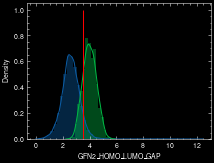

In [16]:
fig, ax = plt.subplots()
sns.distplot(data['GFN2_HOMO_LUMO_GAP'] * 27.2114, ax=ax)
sns.distplot(random_bandgaps, ax=ax)
ax.vlines(3.5, 0, 1.0, color='red')

Let's try this in two settings: (1) we try to use the little data we have to predict the biased distribution and (2) we completely ignore all training data above 3.5 eV and try to predict the unbiased distribution.

## Random split and biased test set

In [26]:
train_set_random, test_set_random = train_test_split(data, train_size=1_000, test_size=200, random_state=42)

In [27]:
PROMPT_TEMPLATE_bandgap_inverse = "What is a molecule with a bandgap of {} eV###"
COMPLETION_TEMPLATE_bandgap_inverse = "{}@@@"


def generate_inverse_photoswitch_prompts(
    data: pd.DataFrame, representation: str = "smiles"
) -> pd.DataFrame:
    prompts = []
    completions = []
    smiles = []
    for i, row in data.iterrows():

        prompt = PROMPT_TEMPLATE_bandgap_inverse.format(
            np.round(row["GFN2_HOMO_LUMO_GAP"] * 27.2114, 1)
        )

        completion = COMPLETION_TEMPLATE_bandgap_inverse.format(row[representation])
        prompts.append(prompt)
        completions.append(completion)
        smiles.append(row["smiles"])

    prompts = pd.DataFrame(
        {"prompt": prompts, "completion": completions, "SMILES": smiles}
    )

    return prompts

In [29]:
train_prompts_random = generate_inverse_photoswitch_prompts(train_set_random)

test_prompts_random = generate_inverse_photoswitch_prompts(test_set_random)

In [25]:
train_prompts_random

,prompt,completion,SMILES
0,What is a molecule with a bandgap of 2.9 eV###,[H]c1nc([C@]2([H])C(=O)N(C([H])([H])[H])C(C([H...,[H]c1nc([C@]2([H])C(=O)N(C([H])([H])[H])C(C([H...
1,What is a molecule with a bandgap of 1.6 eV###,[H]c1nc(N([H])c2c([H])c(Cl)c(C(=O)N([H])[C@]3(...,[H]c1nc(N([H])c2c([H])c(Cl)c(C(=O)N([H])[C@]3(...
2,What is a molecule with a bandgap of 2.3 eV###,[H]/C(=C(/[H])C([H])([H])n1c(-c2c([H])c([H])c(...,[H]/C(=C(/[H])C([H])([H])n1c(-c2c([H])c([H])c(...
3,What is a molecule with a bandgap of 1.7 eV###,[H]c1c([H])c(-c2c([H])c([H])c(N([H])C(=O)c3c([...,[H]c1c([H])c(-c2c([H])c([H])c(N([H])C(=O)c3c([...
4,What is a molecule with a bandgap of 1.9 eV###,[H]c1nc(-n2nc(N([H])c3c([H])c([H])c(C4([H])C([...,[H]c1nc(-n2nc(N([H])c3c([H])c([H])c(C4([H])C([...
...,...,...,...
495,What is a molecule with a bandgap of 2.4 eV###,[H]OC(=O)c1c(N([H])S(=O)(=O)c2c([H])c([H])c([H...,[H]OC(=O)c1c(N([H])S(=O)(=O)c2c([H])c([H])c([H...
496,What is a molecule with a bandgap of 3.6 eV###,[H]N1C([H])([H])C([H])([H])N(C([H])([H])C(=O)N...,[H]N1C([H])([H])C([H])([H])N(C([H])([H])C(=O)N...
497,What is a molecule with a bandgap of 0.7 eV###,[H]c1nc(N([H])c2c([H])c([H])c(F)c(Cl)c2[H])c2c...,[H]c1nc(N([H])c2c([H])c([H])c(F)c(Cl)c2[H])c2c...
498,What is a molecule with a bandgap of 1.7 eV###,[H]C([H])=C([H])C(=O)N([H])c1c([H])c([H])c([H]...,[H]C([H])=C([H])C(=O)N([H])c1c([H])c([H])c([H]...


In [34]:
train_size = len(train_set_random)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename_random = f"run_files/{filename_base}_train_prompts_bandgap_inverse_smiles_{train_size}.jsonl"

train_prompts_random.to_json(train_filename_random, orient="records", lines=True)


valid_filename_random = f"run_files/{filename_base}_valid_prompts_bandgap_inverse_smiles_{train_size}.jsonl"
test_prompts_random.to_json(valid_filename_random, orient="records", lines=True)

In [35]:
modelname_random = fine_tune(train_filename_random, valid_filename_random)   

Fine-tune ft-KBzV2aU0bJBTSK3GKV6vggJG has the status "running" and will not be logged
🎉 wandb sync completed successfully


In [37]:
def test_inverse_model(
    modelname,
    test_prompts,
    df_train,
    max_tokens: int = 250,
    temperatures=None,
    representation="SMILES",
):
    temperatures = temperatures or [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
    train_smiles = df_train["SMILES"].to_list()
    results = []
    for temperature in temperatures:
        try:
            print(f"Testing temperature {temperature} for {representation}")
            result = test_inverse_bandgap(
                test_prompts,
                modelname,
                train_smiles=train_smiles,
                temperature=temperature,
                max_tokens=max_tokens,
                representation=representation,
            )

            results.append(result)
        except Exception as e:
            print(e)
            pass

    return results

In [42]:
random_test_results = test_inverse_model(modelname_random, test_prompts_random, train_prompts_random)

Testing temperature 0 for SMILES


2022-11-30 22:36:49.814 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-11-30 22:36:49.819 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-11-30 22:36:49.861 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 200 samples
2022-11-30 22:36:50.178 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-30 22:38:15.489 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (81.16275694474034, 8.918514126808853e-08)
2022-11-30 22:38:16.252 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.291539715121755

Testing temperature 0.25 for SMILES


2022-11-30 22:39:26.259 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-11-30 22:39:26.262 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-11-30 22:39:26.304 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 142 samples
2022-11-30 22:39:26.527 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-30 22:40:00.127 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (41.89966872982133, 0.00022942514529373565)
2022-11-30 22:40:00.863 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.17189881425441

Testing temperature 0.5 for SMILES


2022-11-30 22:41:11.015 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c(C([H])([H])[H])c([H])c(N([H])C(=O)N([H])c2c([H])c([H])c([H])c([H])c2C([H])([H])[H])c1[H]
2022-11-30 22:41:11.016 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c(C([H])([H])[H])c([H])c(N([H])C(=O)N([H])c2c([H])c([H])c([H])c([H])c2C([H])([H])[H])c1[H]
2022-11-30 22:41:11.067 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 122 samples
2022-11-30 22:41:11.342 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-30 22:42:06.091 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (28.65400579895571, 0.0032444768476936957)
2022-11-30 22:42:06.822 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.366

Testing temperature 0.75 for SMILES


2022-11-30 22:43:16.125 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]/N=C(/c1nc([H])c([H])c([H])c1[H])N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]
2022-11-30 22:43:16.125 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]/N=C(/c1nc([H])c([H])c([H])c1[H])N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]
2022-11-30 22:43:16.188 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 97 samples
2022-11-30 22:43:16.410 | INFO     | gpt3forchem.outpu

Testing temperature 1.0 for SMILES


2022-11-30 22:45:38.665 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]OC([H])([H])[C@@]([H])(C(=O)N([H])S(=O)(=O)c1c([H])c([H])c(-n2c(-c3([H])nc([H])c([H])c3[H])nc2[H])nc1[H])C([H])([H])[H]
2022-11-30 22:45:38.666 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]OC([H])([H])[C@@]([H])(C(=O)N([H])S(=O)(=O)c1c([H])c([H])c(-n2c(-c3([H])nc([H])c([H])c3[H])nc2[H])nc1[H])C([H])([H])[H]
2022-11-30 22:45:38.732 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 54 samples
2022-11-30 22:45:38.828 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-30 22:46:47.499 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (30.06588195373145, 0.002446305404539369)
2022-11-30 22:46:47.859 | DEBUG    | gpt3forchem.output:test_inverse_ba

Testing temperature 1.25 for SMILES


2022-11-30 22:47:58.263 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]Oc1c([H])c([H])c([H])c([C@]2([H])C([H])([H])[C@@]3([H])N(O[H])[C@=O]3C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])[C@@]3([H])O[H])c1[H]
2022-11-30 22:47:58.263 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]Oc1c([H])c([H])c([H])c([C@]2([H])C([H])([H])[C@@]3([H])N(O[H])[C@=O]3C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])[C@@]3([H])O[H])c1[H]
2022-11-30 22:47:58.318 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 21 samples
2022-11-30 22:47:58.461 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
[22:48:20] WARNING: not removing hydrogen atom without neighbors
2022-11-30 22:48:29.443 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (46.90723029860626

Testing temperature 1.5 for SMILES


2022-11-30 22:49:41.937 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1nn2c(C(=O)N([H])C([H])([H])c3nc(N4C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])SC(=O)OC5C([H])([H])[H])C([H])([H])O4)nc(-n3c3c([H])c([H])n([P]^UP)(Vert)c3[H])c3c([H])nn32)nc(N2[H])c2c([H])n2c([H])c([H])c([H])c12
2022-11-30 22:49:41.938 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1nn2c(C(=O)N([H])C([H])([H])c3nc(N4C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])SC(=O)OC5C([H])([H])[H])C([H])([H])O4)nc(-n3c3c([H])c([H])n([P]^UP)(Vert)c3[H])c3c([H])nn32)nc(N2[H])c2c([H])n2c([H])c([H])c([H])c12
2022-11-30 22:49:41.975 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 10 samples
2022-11-30 22:49:42.057 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
[22:49:50] WARNING: not removi

In [45]:
timestamp = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())

In [46]:
save_pickle(f"run_files/{timestamp}-random_test_results_extrapolation_smiles.pkl", random_test_results)

In [47]:
smiles_500_random_sets = []

for res in random_test_results:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_500_random_sets.append(result)

for res in smiles_500_random_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_xtb_opt/{timestamp}_smiles_500_random_sets_{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

## Extrapolation test

In [48]:
train_set_extrapolation = data[data['GFN2_HOMO_LUMO_GAP'] * 27.2114 < 3.5].sample(1000)
test_set_extrapolation = data[data['GFN2_HOMO_LUMO_GAP'] * 27.2114 > 3.5].sample(200)

In [53]:
random_bandgaps = np.random.normal(4.0, 0.5, size=200) / 27.2114

In [54]:
test_set_extrapolation['GFN2_HOMO_LUMO_GAP'] = random_bandgaps

In [55]:
train_prompts_extrapolation = generate_inverse_photoswitch_prompts(train_set_extrapolation)

test_prompts_extrapolation = generate_inverse_photoswitch_prompts(test_set_extrapolation)

In [56]:
test_prompts_extrapolation

,prompt,completion,SMILES
0,What is a molecule with a bandgap of 3.6 eV###,[H]c1c([H])c2c(c([H])c1N([H])C(=O)C([H])([H])[...,[H]c1c([H])c2c(c([H])c1N([H])C(=O)C([H])([H])[...
1,What is a molecule with a bandgap of 4.7 eV###,[H]C1=C([H])C([H])([H])N(C(=O)c2c([H])c([H])c(...,[H]C1=C([H])C([H])([H])N(C(=O)c2c([H])c([H])c(...
2,What is a molecule with a bandgap of 3.9 eV###,[H]Oc1c([H])c([H])c2c3c1O[C@@]1([H])[C@]4(OC([...,[H]Oc1c([H])c([H])c2c3c1O[C@@]1([H])[C@]4(OC([...
3,What is a molecule with a bandgap of 3.4 eV###,[H]OC(=O)[C@@]([H])(N([H])[H])[C@@]1([H])C(F)(...,[H]OC(=O)[C@@]([H])(N([H])[H])[C@@]1([H])C(F)(...
4,What is a molecule with a bandgap of 3.6 eV###,[H]C1=C2N(N([H])[H])C(=O)C([H])([H])C([H])([H]...,[H]C1=C2N(N([H])[H])C(=O)C([H])([H])C([H])([H]...
...,...,...,...
195,What is a molecule with a bandgap of 3.6 eV###,[H]c1nc([H])c([H])c(N2C([H])([H])C([H])([H])N(...,[H]c1nc([H])c([H])c(N2C([H])([H])C([H])([H])N(...
196,What is a molecule with a bandgap of 4.3 eV###,[H]OC(=O)[C@@]1([H])N(C(=O)[C@]([H])(C([H])([H...,[H]OC(=O)[C@@]1([H])N(C(=O)[C@]([H])(C([H])([H...
197,What is a molecule with a bandgap of 3.8 eV###,[H]OC([H])([H])[C@](N([H])[H])(C([H])([H])OP(=...,[H]OC([H])([H])[C@](N([H])[H])(C([H])([H])OP(=...
198,What is a molecule with a bandgap of 4.0 eV###,[H]c1c([H])c([C@@]2([H])C([H])([H])[C@@]3([H])...,[H]c1c([H])c([C@@]2([H])C([H])([H])[C@@]3([H])...


In [58]:
train_size = len(train_set_random)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename_extrapolation = f"run_files/{filename_base}_train_prompts_bandgap_inverse_smiles_extrapolation_{train_size}.jsonl"

train_prompts_extrapolation.to_json(train_filename_extrapolation, orient="records", lines=True)


valid_filename_extrapolation = f"run_files/{filename_base}_valid_prompts_bandgap_inverse_smiles_extrapolation_{train_size}.jsonl"
test_prompts_extrapolation.to_json(valid_filename_extrapolation, orient="records", lines=True)

In [59]:
modelname_extrapolation =  fine_tune(train_filename_extrapolation, valid_filename_extrapolation)   

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [63]:
extrapolation_test_results = test_inverse_model(modelname_extrapolation, test_prompts_extrapolation, train_prompts_extrapolation)

Testing temperature 0 for SMILES


2022-12-01 10:44:38.964 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-12-01 10:44:38.965 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-12-01 10:44:38.990 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 200 samples
2022-12-01 10:44:39.035 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 10:45:14.125 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (74.70535697709458, 3.2447044114324397e-07)
2022-12-01 10:45:14.845 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: nan


Testing temperature 0.25 for SMILES


2022-12-01 10:46:24.738 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1nc(N([H])c2c([H])c([H])c(C(=O)N([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c([H])c2[H])nc(C([H])([H])[H])c1C(=O)N1C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
2022-12-01 10:46:24.739 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1nc(N([H])c2c([H])c([H])c(C(=O)N([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c([H])c2[H])nc(C([H])([H])[H])c1C(=O)N1C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
2022-12-01 10:46:24.790 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 162 samples
2022-12-01 10:46:24.831 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 10:47:25.254 | DEBUG    | 

Testing temperature 0.5 for SMILES


2022-12-01 10:48:37.546 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])C([H])([H])[H])c([H])c1[H]
2022-12-01 10:48:37.547 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])C([H])([H])[H])c([H])c1[H]
2022-12-01 10:48:37.605 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 135 samples
2022-12-01 10:48:37.649 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 10:49:26.784 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (29.100233479828177, 0.002967466572828484)
2022-12-01 10:49:27.610 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed

Testing temperature 0.75 for SMILES


2022-12-01 10:50:38.181 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1nc([H])c([H])c(N([H])C(=O)N([H])C([H])([H])C([H])([H])[C@]2([H])C([H])([H])[C@]3(C(=O)N(C([H])([H])[H])C([H])([H])[C@]4([H])C([H])([H])C([H])([H])[C@@]23C([H])([H])C([H])([H])C([H])([H])[C@]([H])(C(=O)N([H])C([H])([H])c3c([H])c([H])c(F)c([H])c3[H])C([H])([H])[C@]2([H])C([H])([H])[H]
2022-12-01 10:50:38.181 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1nc([H])c([H])c(N([H])C(=O)N([H])C([H])([H])C([H])([H])[C@]2([H])C([H])([H])[C@]3(C(=O)N(C([H])([H])[H])C([H])([H])[C@]4([H])C([H])([H])C([H])([H])[C@@]23C([H])([H])C([H])([H])C([H])([H])[C@]([H])(C(=O)N([H])C([H])([H])c3c([H])c([H])c(F)c([H])c3[H])C([H])([H])[C@]2([H])C([H])([H])[H]
2022-12-01 10:50:38.232 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 117 samples
2022-12-01 10:50:38.271 | INFO     | gpt3forchem.output:_load_che